In [196]:
#import os

# args.output_attention = True

#exp = Exp(args)

#model = exp.model

#setting = 'ETTh1_96_24_Autoformer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0'
#path = os.path.join(args.checkpoints,setting,'checkpoint.pth')
#model.load_state_dict(torch.load(path))

In [197]:
import torch
import os
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())
print(torch.cuda.current_device())
torch.cuda.set_device(0)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
# os.environ["CUDA_VISIBLE_DEVICES"] = '0' #disable CUDA by setting CUDA_VISIBLE_DEVICES to an empty string 


True
1
NVIDIA GeForce GTX 1660 Ti
0


In [213]:
import argparse
import os
import torch
from exp.exp_main import Exp_Main
import random
import numpy as np
from utils.tools import dotdict

fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')

# basic config
parser.add_argument('--is_training', type=int, required=True, default=1, help='status')
parser.add_argument('--model_id', type=str, required=True, default='test', help='model id')
parser.add_argument('--model', type=str, required=True, default='Autoformer',
                    help='model name, options: [Autoformer, Informer, Transformer]')

# data loader
parser.add_argument('--data', type=str, required=True, default='ETTm1', help='dataset type')
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length')
parser.add_argument('--pred_len', type=int, default=96, help='prediction sequence length')


# DLinear
parser.add_argument('--individual', action='store_true', default=False, help='DLinear: a linear layer for each variate(channel) individually')

# Formers 
parser.add_argument('--embed_type', type=int, default=0, help='0: default 1: value embedding + temporal embedding + positional embedding 2: value embedding + temporal embedding 3: value embedding + positional embedding 4: value embedding')
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size') # DLinear with --individual, use this hyperparameter as the number of channels
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=7, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')
parser.add_argument('--itr', type=int, default=2, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test', help='exp description')
parser.add_argument('--loss', type=str, default='mse', help='loss function')
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')
parser.add_argument('--test_flop', action='store_true', default=False, help='See utils/tools for usage')

# args = parser.parse_args()
args = dotdict()

# basic config
args.is_training = 1
args.model_id = 'gold_seq336_0_30'
args.model = 'Informer' #Autoformer/Informer/Transformer/DLinear/NLinear

# data loader
args.data = 'custom'
args.root_path = './dataset/commodity/'
args.data_path ='silver_data.csv' 
args.features = 'S'
args.target = 'OT'
args.freq = 'b'
args.checkpoints = './checkpoints/'

# forecasting task
args.seq_len = 96
args.label_len = 56
args.pred_len = 56

# DLinear
args.individual = False

# Formers 
args.embed_type = 0
args.enc_in = 1
args.dec_in = 1
args.c_out = 1
args.d_model = 512
args.n_heads = 8
args.e_layers = 2
args.d_layers = 1
args.d_ff = 2048
args.moving_avg = 25
args.factor = 3
args.distil = True
args.dropout = 0.05
args.embed = 'timeF'
args.do_predict = True

# optimization
args.num_workers = 10
args.itr = 1
args.train_epochs = 20
args.patience = 3
args.learning_rate = 0.0005
args.batch_size = 8
args.lradj = 'type1'
args.des = 'Exp'

# GPU
args.gpu = 0
args.devices = '0'
args.use_gpu = True
args.use_multi_gpu = False

print('Args in experiment:')
print(args)

Exp = Exp_Main




Args in experiment:
{'is_training': 1, 'model_id': 'gold_seq336_0_30', 'model': 'Informer', 'data': 'custom', 'root_path': './dataset/commodity/', 'data_path': 'silver_data.csv', 'features': 'S', 'target': 'OT', 'freq': 'b', 'checkpoints': './checkpoints/', 'seq_len': 96, 'label_len': 56, 'pred_len': 56, 'individual': False, 'embed_type': 0, 'enc_in': 1, 'dec_in': 1, 'c_out': 1, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'moving_avg': 25, 'factor': 3, 'distil': True, 'dropout': 0.05, 'embed': 'timeF', 'do_predict': True, 'num_workers': 10, 'itr': 1, 'train_epochs': 20, 'patience': 3, 'learning_rate': 0.0005, 'batch_size': 8, 'lradj': 'type1', 'des': 'Exp', 'gpu': 0, 'devices': '0', 'use_gpu': True, 'use_multi_gpu': False}


In [214]:
if args.is_training:
    for ii in range(args.itr):
        # setting record of experiments
        setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
            args.model_id,
            args.model,
            args.data,
            args.features,
            args.seq_len,
            args.label_len,
            args.pred_len,
            args.d_model,
            args.n_heads,
            args.e_layers,
            args.d_layers,
            args.d_ff,
            args.factor,
            args.embed,
            args.distil,
            args.des, ii)

        exp = Exp(args)  # set experiments
        print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
        exp.train(setting)

        print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
        exp.test(setting)

        torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : gold_seq336_0_30_Informer_custom_ftS_sl96_ll56_pl56_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 1608
val 197
test 447
	iters: 100, epoch: 1 | loss: 0.2021711
	speed: 0.1426s/iter; left time: 559.0804s
	iters: 200, epoch: 1 | loss: 0.1816181
	speed: 0.0554s/iter; left time: 211.5474s
Epoch: 1 cost time: 20.896006107330322
Epoch: 1, Steps: 201 | Train Loss: 0.2185918 Vali Loss: 1.1887875 Test Loss: 0.7265239
Validation loss decreased (inf --> 1.188787).  Saving model ...
Updating learning rate to 0.0005
	iters: 100, epoch: 2 | loss: 0.0542300
	speed: 0.3792s/iter; left time: 1410.4475s
	iters: 200, epoch: 2 | loss: 0.0947414
	speed: 0.0558s/iter; left time: 202.0916s
Epoch: 2 cost time: 21.19674849510193
Epoch: 2, Steps: 201 | Train Loss: 0.1081224 Vali Loss: 0.8881936 Test Loss: 0.8938068
Validation loss decreased (1.188787 --> 0.888194).  Saving model ...
Updating learning rate to 0.00025
	iters: 100, epoch: 

In [16]:
import pandas as pd
exp.args.root_path = './dataset/commodity/'
exp.args.data_path = 'gold_data.csv'

df = pd.read_csv(os.path.join(args.root_path, args.data_path))
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2514 entries, 0 to 2513
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       2514 non-null   object 
 1   Open       2514 non-null   float64
 2   High       2514 non-null   float64
 3   Low        2514 non-null   float64
 4   OT         2514 non-null   float64
 5   Adj Close  2514 non-null   float64
 6   Volume     2514 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 137.6+ KB


In [18]:
# df['date'] = pd.to_datetime(df['date'])
# # df.to_csv(os.path.join(args.root_path, args.data_path), index=False) 
# last_date = df['date'].max()
# new_rows = pd.DataFrame(columns=df.columns, index=range(1, 31))
# new_rows['date'] = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)
# df = pd.concat([df, new_rows], sort=False)
# df.tail()



In [19]:
if args.do_predict:
    print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    prediction=exp.predict(setting, True)
    prediction = np.load('./results/'+setting+'/real_prediction.npy')

    prediction.shape
    

>>>>>>>predicting : gold_seq336_0_30_Autoformer_custom_ftMS_sl336_ll14_pl14_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
pred 1


In [20]:
# from torch.utils.data import DataLoader
# import pandas as pd
# import numpy as np
# from datetime import datetime

# date_obj = '10/14/2022'
# #date_obj = datetime.strptime(date, '%m/%d/%Y')

# print(date_obj)

# def create_prediction_dataset(data, seq_len, pred_len, start_date):
#     start_index = data[data['date'] == start_date].index[0]
#     end_index = start_index + args.seq_len + args.pred_len
#     prediction_data = data.iloc[start_index:end_index]
#     return prediction_data

# # Create the prediction dataset

# pred_data = create_prediction_dataset(df, args.seq_len, args.pred_len, date_obj)
# pred_data.head()
# print(pred_data)

# pred_loader = DataLoader(pred_data, batch_size = args.batch_size, shuffle=False)

# predictions = exp.predict(setting, pred_loader, True)

In [21]:
from data_provider.data_loader import Dataset_Pred
from torch.utils.data import DataLoader
from data_provider.data_loader import Dataset_Custom
Data = Dataset_Custom

freq = 'b'

Data = Dataset_Custom
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target, # HULL here
    freq=args.freq # 'h': hourly, 't':minutely
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

print(len(data_set), len(data_loader))


489 489


In [ ]:
exp.predict(setting, data_loader)

In [ ]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)

preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
print(preds.shape, trues.shape)

torch.Size([1, 6, 14])
torch.Size([14])


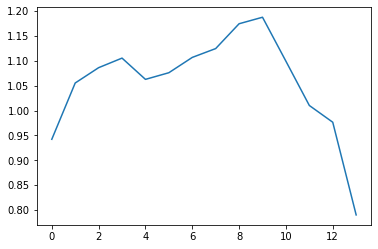

torch.Size([14])
torch.Size([14])


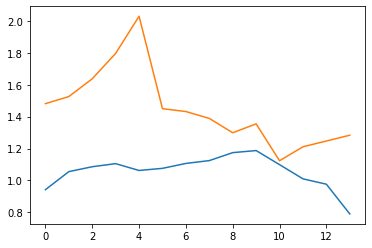

torch.Size([14])


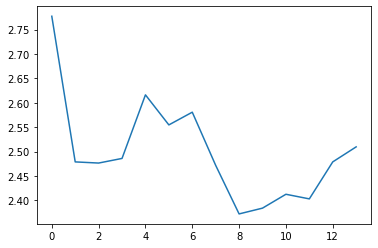

torch.Size([14])
torch.Size([14])


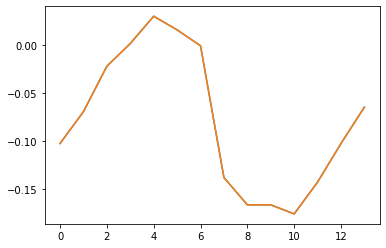

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib
data_pred = np.load('./results/'+setting+'/real_prediction.npy')
data_pred = torch.from_numpy(data_pred).permute(0,2,1)

plt.figure()
print(data_pred.shape)
#预测OT
plt.plot(data_pred[-1,-1,:])
print(data_pred[-1,-1,:].shape)
plt.show()
plt.plot(data_pred[0,-1,:])
print(data_pred[0,-1,:].shape)
#plt.show()
# draw HUFL prediction
plt.plot(data_pred[0,0,:])
print(data_pred[-1,-1,:].shape)
plt.show()
'''
Ground Truth
'''
data_gt = np.load('./results/'+setting+'/true.npy')
data_gt = torch.from_numpy(data_gt).permute(0,2,1)

# OT
plt.plot(data_gt[-1,-1,:])
print(data_gt[-1,-1,:].shape)
plt.show()
plt.plot(data_gt[0,-1,:])
print(data_gt[0,-1,:].shape)
#plt.show()
# draw HUFL prediction
plt.plot(data_gt[0,0,:])
print(data_gt[-1,-1,:].shape)
plt.show()



In [23]:
if (args.model == 'DLinear'):
    model_name = setting
    for root, dirs, files in os.walk("checkpoints"):
        for name in files:
            model_path = os.path.join(root, name)
            if model_name not in model_path:
                continue
            weights = torch.load(model_path,map_location=torch.device('cpu'))
            weights_list = {'seasonal': weights['Linear_Seasonal.weight'].numpy(),
                            'trend': weights['Linear_Trend.weight'].numpy()}

            #print(root)
            #print(root.split('/'))

            save_root = 'weights_plot/%s'%root.split('\\')[1] #changed from save_root = 'weights_plot/%s'%root.split('/')[1]
            if not os.path.exists('weights_plot'):
                os.mkdir('weights_plot')
            if not os.path.exists(save_root):
                os.mkdir(save_root)
        
            for w_name,weight in weights_list.items():
                fig,ax=plt.subplots()
                im=ax.imshow(weight,cmap='plasma_r')
                fig.colorbar(im,pad=0.03)
                plt.savefig(os.path.join(save_root,w_name + '.pdf'),dpi=500)
                plt.show()
                plt.close()